# Image Super-Resolution Using Deep Convolutional Networks

This notebook is based off of [this paper](https://arxiv.org/pdf/1501.00092v3.pdf)

## Standard Copy Pasted code

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
## Install and import torch metrics
# !pip install torchmetrics -q
# import torchmetrics

!rm DeconvModels.py
!rm training_functions.py
!rm blur_functions.py
!rm Datasets.py
!rm data_augmentation.py

!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/DeconvModels.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/LossModules.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/training_functions.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/blur_functions.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Datasets/Datasets.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/data_augmentation.py -q

from DeconvModels import Deconv2D, Deconv2D
from LossModules import DCT
from training_functions import train_regression_model, train_classification_model
import blur_functions as blur
from Datasets import Div2k
from data_augmentation import RandomCropIsr

rm: cannot remove 'DeconvModels.py': No such file or directory
rm: cannot remove 'training_functions.py': No such file or directory
rm: cannot remove 'blur_functions.py': No such file or directory
rm: cannot remove 'Datasets.py': No such file or directory
rm: cannot remove 'data_augmentation.py': No such file or directory


# Deconv

## Download Dataset

In [3]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip -q
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip -q
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X3.zip -q
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip -q

In [4]:
import zipfile
zip_ref = zipfile.ZipFile('DIV2K_train_HR.zip', "r")
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('DIV2K_train_LR_bicubic_X2.zip', "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
hr_path = 'DIV2K_train_HR'
lr_path = 'DIV2K_train_LR_bicubic/X2'

IMG_SIZE = (32, 32)

random_crop = RandomCropIsr(IMG_SIZE[0])

data = Div2k(lr_path, hr_path, transform=random_crop, ds_length=20)
dataloader = DataLoader(data, batch_size=4, shuffle=False)

x_batch, y_batch = next(iter(dataloader))

x_batch.size(), y_batch.size()

(torch.Size([4, 1, 16, 16]), torch.Size([4, 1, 32, 32]))

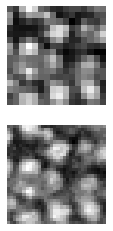

In [6]:
plt.subplots(2, 1)

plt.subplot(2, 1, 1)
plt.imshow(x_batch[0, 0, :, :], cmap='gray')
plt.axis('off')


plt.subplot(2, 1, 2)
plt.imshow(y_batch[0, 0, :, :], cmap='gray')
plt.axis('off')
plt.show()

In [7]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1, upscale_factor=2, deconv=False):
        super(SRCNN, self).__init__()
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, num_channels * (upscale_factor ** 2), kernel_size=5, padding=2)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU()
        if deconv:
            self.conv1 = Deconv2D(1, 64, (9, 9))
        else:
            self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.pixel_shuffle(x)
        return x

class MSE_with_DCT(nn.Module):
    def __init__(self, img_size=(96, 96)):
        super(MSE_with_DCT, self).__init__()
        self.mse = nn.MSELoss()
        self.dct = DCT(img_size)

    def forward(self, x, y):
        x = self.dct(x)
        y = self.dct(y)
        loss = self.mse(x, y)
        return loss

In [8]:
channels = x_batch.size(1)
srcnn = SRCNN(channels)

criterion = MSE_with_DCT(img_size=IMG_SIZE)
criterion = criterion.to(device)

optimizer = optim.Adam(srcnn.parameters(), lr=1e-4)

In [9]:
resize = T.Resize(IMG_SIZE)

x_batch, y_batch = next(iter(dataloader))
x_batch = resize(x_batch)
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)

loss = criterion(x_batch, y_batch)
loss.item()

0.0007671862258575857

In [10]:
param = next(criterion.parameters())
print(param)
print(param.device)

Parameter containing:
tensor([[0.1768, 0.1768, 0.1768,  ..., 0.1768, 0.1768, 0.1768],
        [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
        ...,
        [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500]],
       device='cuda:0')
cuda:0


In [11]:
history, _ = train_regression_model(srcnn, criterion, optimizer, dataloader, num_epochs=30)

Epoch 0001 loss: 1.03158
Epoch 0002 loss: 1.55335
Epoch 0003 loss: 0.97214
Epoch 0004 loss: 0.66857
Epoch 0005 loss: 0.52692
Epoch 0006 loss: 0.76794
Epoch 0007 loss: 0.91751
Epoch 0008 loss: 0.50235
Epoch 0009 loss: 0.48733
Epoch 0010 loss: 0.26108
Epoch 0011 loss: 0.15836
Epoch 0012 loss: 0.19805
Epoch 0013 loss: 0.15553
Epoch 0014 loss: 0.18750
Epoch 0015 loss: 0.17174
Epoch 0016 loss: 0.16022
Epoch 0017 loss: 0.16236
Epoch 0018 loss: 0.17867
Epoch 0019 loss: 0.19746
Epoch 0020 loss: 0.13733
Epoch 0021 loss: 0.15044
Epoch 0022 loss: 0.11851
Epoch 0023 loss: 0.14256
Epoch 0024 loss: 0.12898
Epoch 0025 loss: 0.15665
Epoch 0026 loss: 0.14974
Epoch 0027 loss: 0.14324
Epoch 0028 loss: 0.13214
Epoch 0029 loss: 0.14185
Epoch 0030 loss: 0.10984


Text(0.5, 1.0, 'Original')

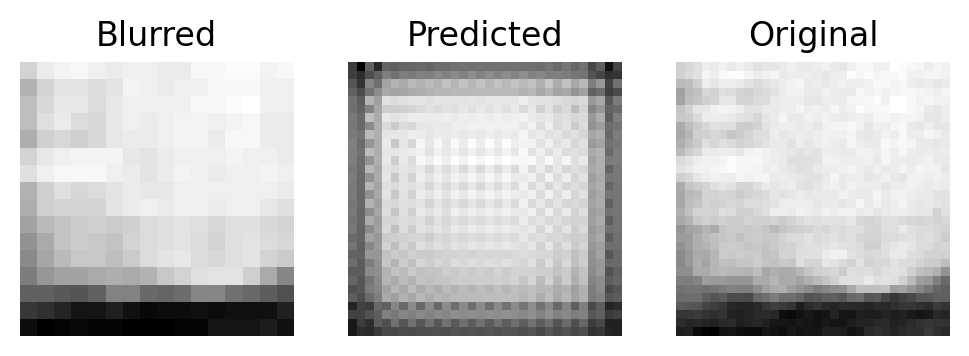

In [12]:
srcnn = srcnn.to("cpu")
srcnn.eval()
X, y = next(iter(dataloader))

y_pred = srcnn(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,:,:,:].permute(1, 2, 0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Original')

In [13]:
model_deconv = SRCNN(deconv=True)


criterion = MSE_with_DCT(img_size=IMG_SIZE)
criterion = criterion.to(device)
optimizer = optim.Adam(model_deconv.parameters(), lr=1e-3)

In [14]:
history, _ = train_regression_model(model_deconv, criterion, optimizer, dataloader, num_epochs=30)

Epoch 0001 loss: 1.30294
Epoch 0002 loss: 0.96801
Epoch 0003 loss: 0.24571
Epoch 0004 loss: 0.18791
Epoch 0005 loss: 0.14244
Epoch 0006 loss: 0.14463
Epoch 0007 loss: 0.15356
Epoch 0008 loss: 0.14466
Epoch 0009 loss: 0.09448
Epoch 0010 loss: 0.07780
Epoch 0011 loss: 0.09154
Epoch 0012 loss: 0.08172
Epoch 0013 loss: 0.07313
Epoch 0014 loss: 0.05153
Epoch 0015 loss: 0.05703
Epoch 0016 loss: 0.05805
Epoch 0017 loss: 0.03814
Epoch 0018 loss: 0.03893
Epoch 0019 loss: 0.02792
Epoch 0020 loss: 0.02620
Epoch 0021 loss: 0.01691
Epoch 0022 loss: 0.01176
Epoch 0023 loss: 0.01647
Epoch 0024 loss: 0.01614
Epoch 0025 loss: 0.01720
Epoch 0026 loss: 0.00955
Epoch 0027 loss: 0.01558
Epoch 0028 loss: 0.01133
Epoch 0029 loss: 0.01063
Epoch 0030 loss: 0.01673


Text(0.5, 1.0, 'Original')

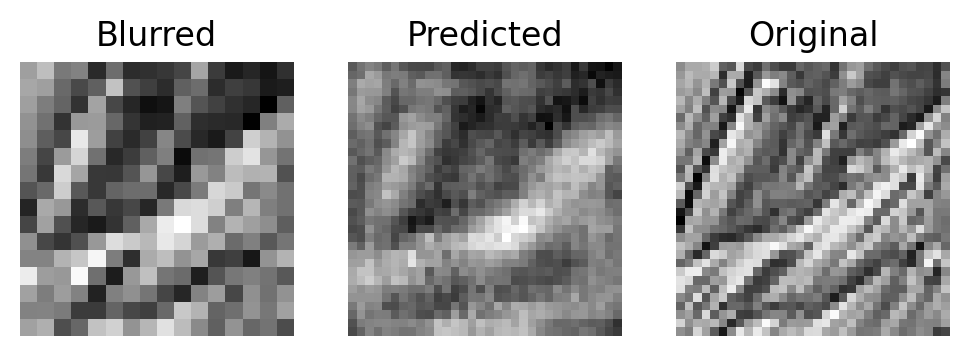

In [18]:
model_deconv = model_deconv.to("cpu")
model_deconv.eval()
X, y = next(iter(dataloader))

y_pred = model_deconv(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,:,:,:].permute(1, 2, 0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Original')

In [16]:
print(model_deconv.conv1)
print(srcnn.conv1)

Deconv2D()
Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))


Text(0.5, 1.0, 'Predicted SRCNN')

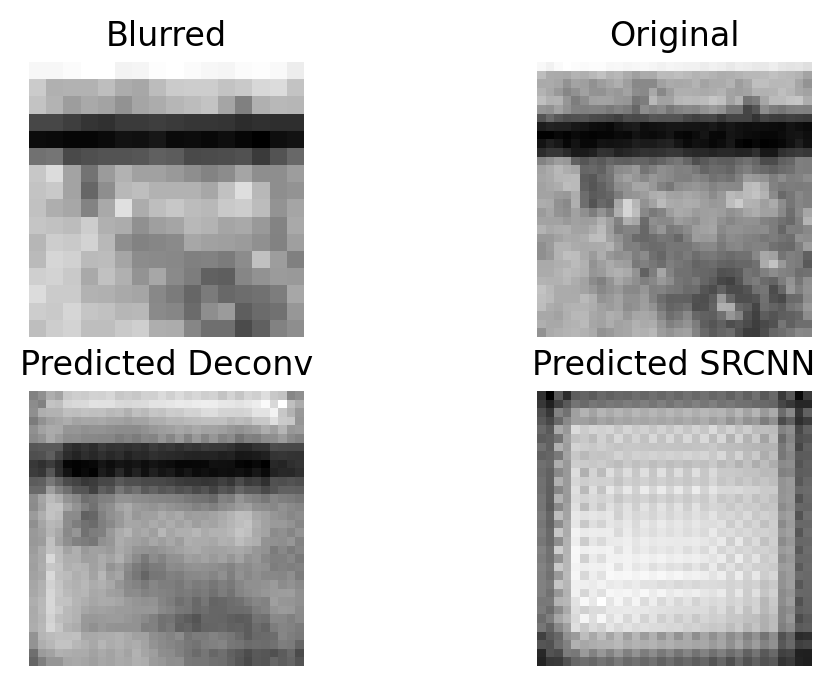

In [19]:
model_deconv = model_deconv.to("cpu")
model_deconv.eval()
X, y = next(iter(dataloader))

y_pred_deconv = model_deconv(X)
y_pred_srcnn = srcnn(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(2, 2)

plt.subplot(2, 2, 1)
plt.imshow(X[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(2, 2, 2)
plt.imshow(y[i,:,:,:].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 3)
plt.imshow(y_pred_deconv[i,:,:,:].permute(1, 2, 0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted Deconv')

plt.subplot(2, 2, 4)
plt.imshow(y_pred_srcnn[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted SRCNN')

